# Baseline analysis 

The purpose of this notebook is to analyse the model performance such as the bias with regard to differences between ethnic groups. Different aspects of each model shall be checked to draw conclusions and compare the performance between the chosen models.

As final models the following 3 algorithms were chosen:
* FaceNet512
* ArcFace
* VGG-Face

## TO DO

* Plot histograms with plt.hist(img.flat, bins=100, range=(0, 255))


In [1]:
%cd /tf/notebooks

/tf/notebooks


In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
import itertools
from itertools import permutations
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import pickle
from PIL import Image
from sklearn.metrics import roc_auc_score, accuracy_score
import seaborn as sns
from skimage.segmentation import mark_boundaries
from sklearn.metrics import roc_auc_score, classification_report, precision_score, accuracy_score
from sklearn.preprocessing import MinMaxScaler
import scipy.stats as st
import tensorflow as tf

from utils import (
    calculate_confidence_interval, calculate_performance_per_threshold,
    count_distances,plot_performance_per_threshold,
    get_metric_comparision, plot_score_distribution,
    perform_significance_test, calculate_distribution_difference
)

import cv2
from deepface import DeepFace


In [30]:
def load_image(shape,path,preprocessing = None):
    if preprocessing is not None:
        img = preprocessing(path)
        img = resize(img,shape)
    else:
        img = Image.open(path).resize(shape)
        img = np.array(img)
    return img

## Example

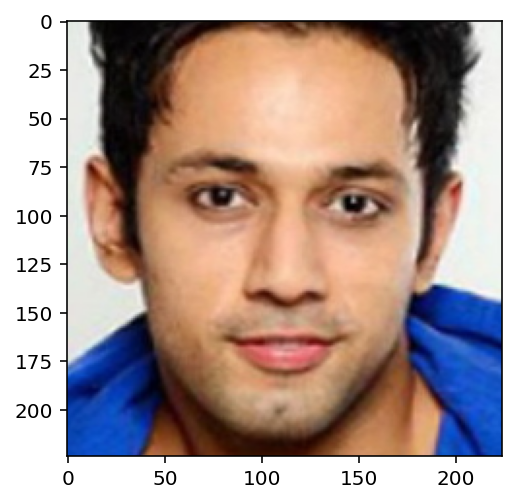

In [6]:
indian_img_path = 'data/race_per_7000/Indian/m.0l8nmsx/000016_00@hi.jpg'
indian_img = load_image(path=indian_img_path,shape=(224,224), preprocessing = None)
plt.imshow(indian_img);

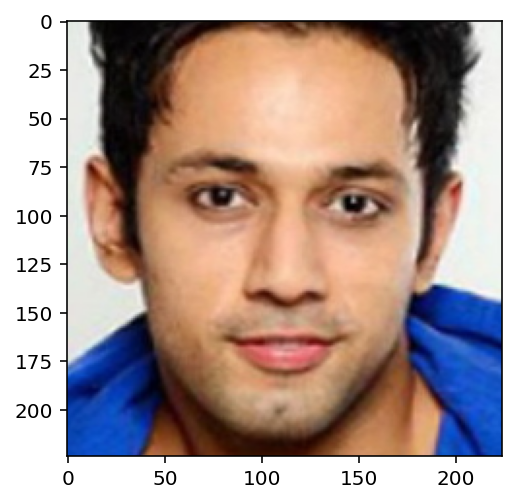

In [7]:
indian_img = load_image(path=indian_img_path,shape=(224,224), preprocessing = None)
plt.imshow(indian_img);

# Evaluation

## Performance comparison

Due to the balanced target labels (50% pairs and 50% non-pairs) we chose to use Accuracz and AUROC as evaluation metrics.

### Facenet512

In [8]:
facenet_summary = get_metric_comparision('facenet', roc_auc_score)

facenet_summary.sort_values('mean', ascending=False)

,race,mean,lower_ci,higher_ci
0,Indian,0.937456,0.936495,0.938417
0,Asian,0.929452,0.928539,0.930365
0,African,0.903244,0.902090,0.904399
0,Caucasian,0.894267,0.893004,0.895531


In [9]:
facenet_summary = get_metric_comparision('facenet', accuracy_score)

facenet_summary.sort_values('mean', ascending=False)

,race,mean,lower_ci,higher_ci
0,Indian,0.864940,0.863706,0.866174
0,Asian,0.855883,0.854572,0.857195
0,African,0.831323,0.829983,0.832664
0,Caucasian,0.776937,0.775377,0.778497


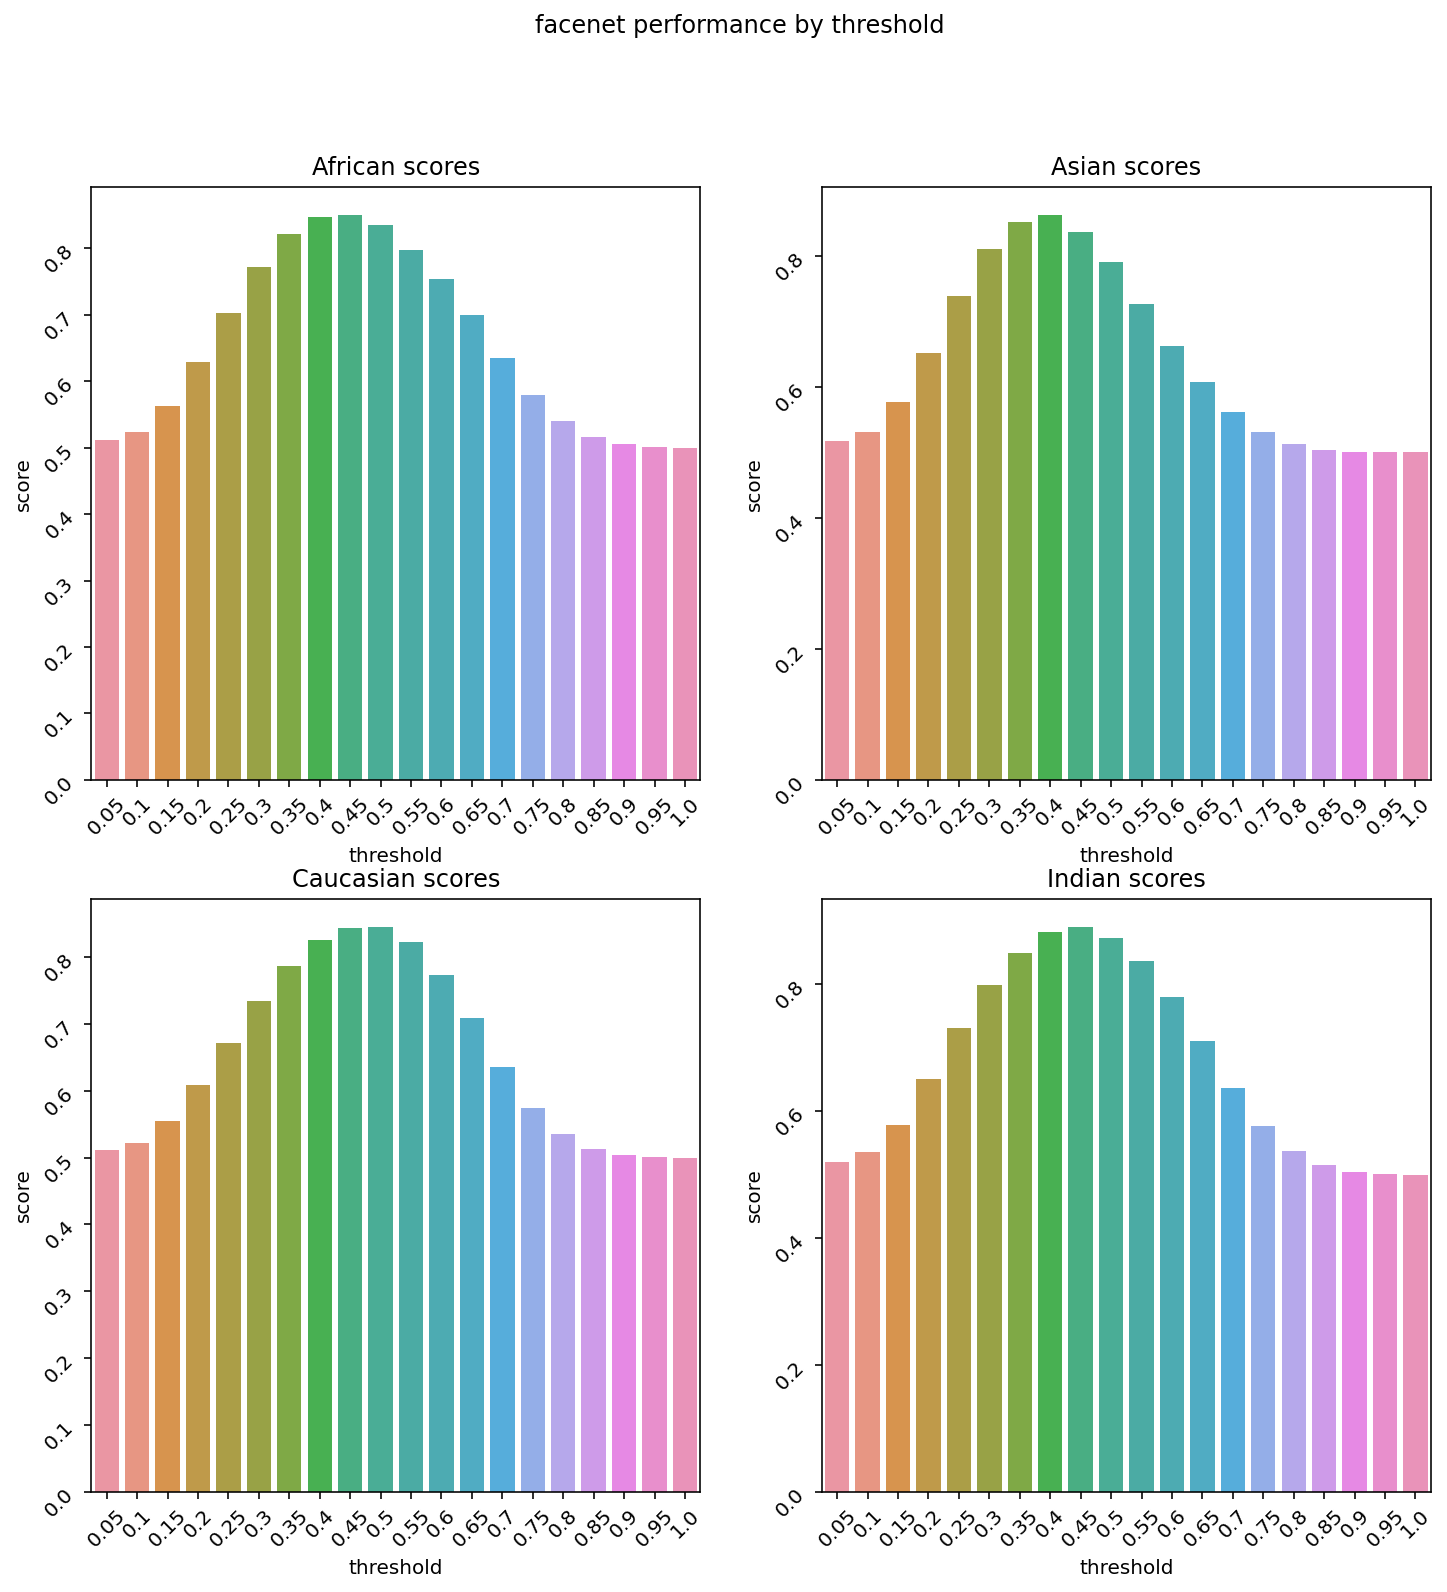

In [10]:
plot_performance_per_threshold('facenet')

**Result**:
* Significant performance drop from Indian to Asian (appx. 10% AUROC and accuracy)
* Interestingly Indian lower CI is higher than higher CI of Caucasians
* CI of Asians is also wider
* Best performing thresholds differ. Especially Asian which tells us that one threshold might not make sense

### VGG-Face

In [11]:
vgg_summary = get_metric_comparision('vgg_face', roc_auc_score)

vgg_summary.sort_values('mean', ascending=False)

,race,mean,lower_ci,higher_ci
0,Indian,0.893889,0.892702,0.895075
0,Asian,0.876938,0.875705,0.878171
0,Caucasian,0.826154,0.824587,0.827721
0,African,0.819776,0.818273,0.821279


In [12]:
vgg_summary = get_metric_comparision('vgg_face', accuracy_score)

vgg_summary.sort_values('mean', ascending=False)

,race,mean,lower_ci,higher_ci
0,Indian,0.757957,0.756460,0.759454
0,Caucasian,0.754120,0.752555,0.755685
0,African,0.702757,0.701122,0.704391
0,Asian,0.688100,0.686519,0.689681


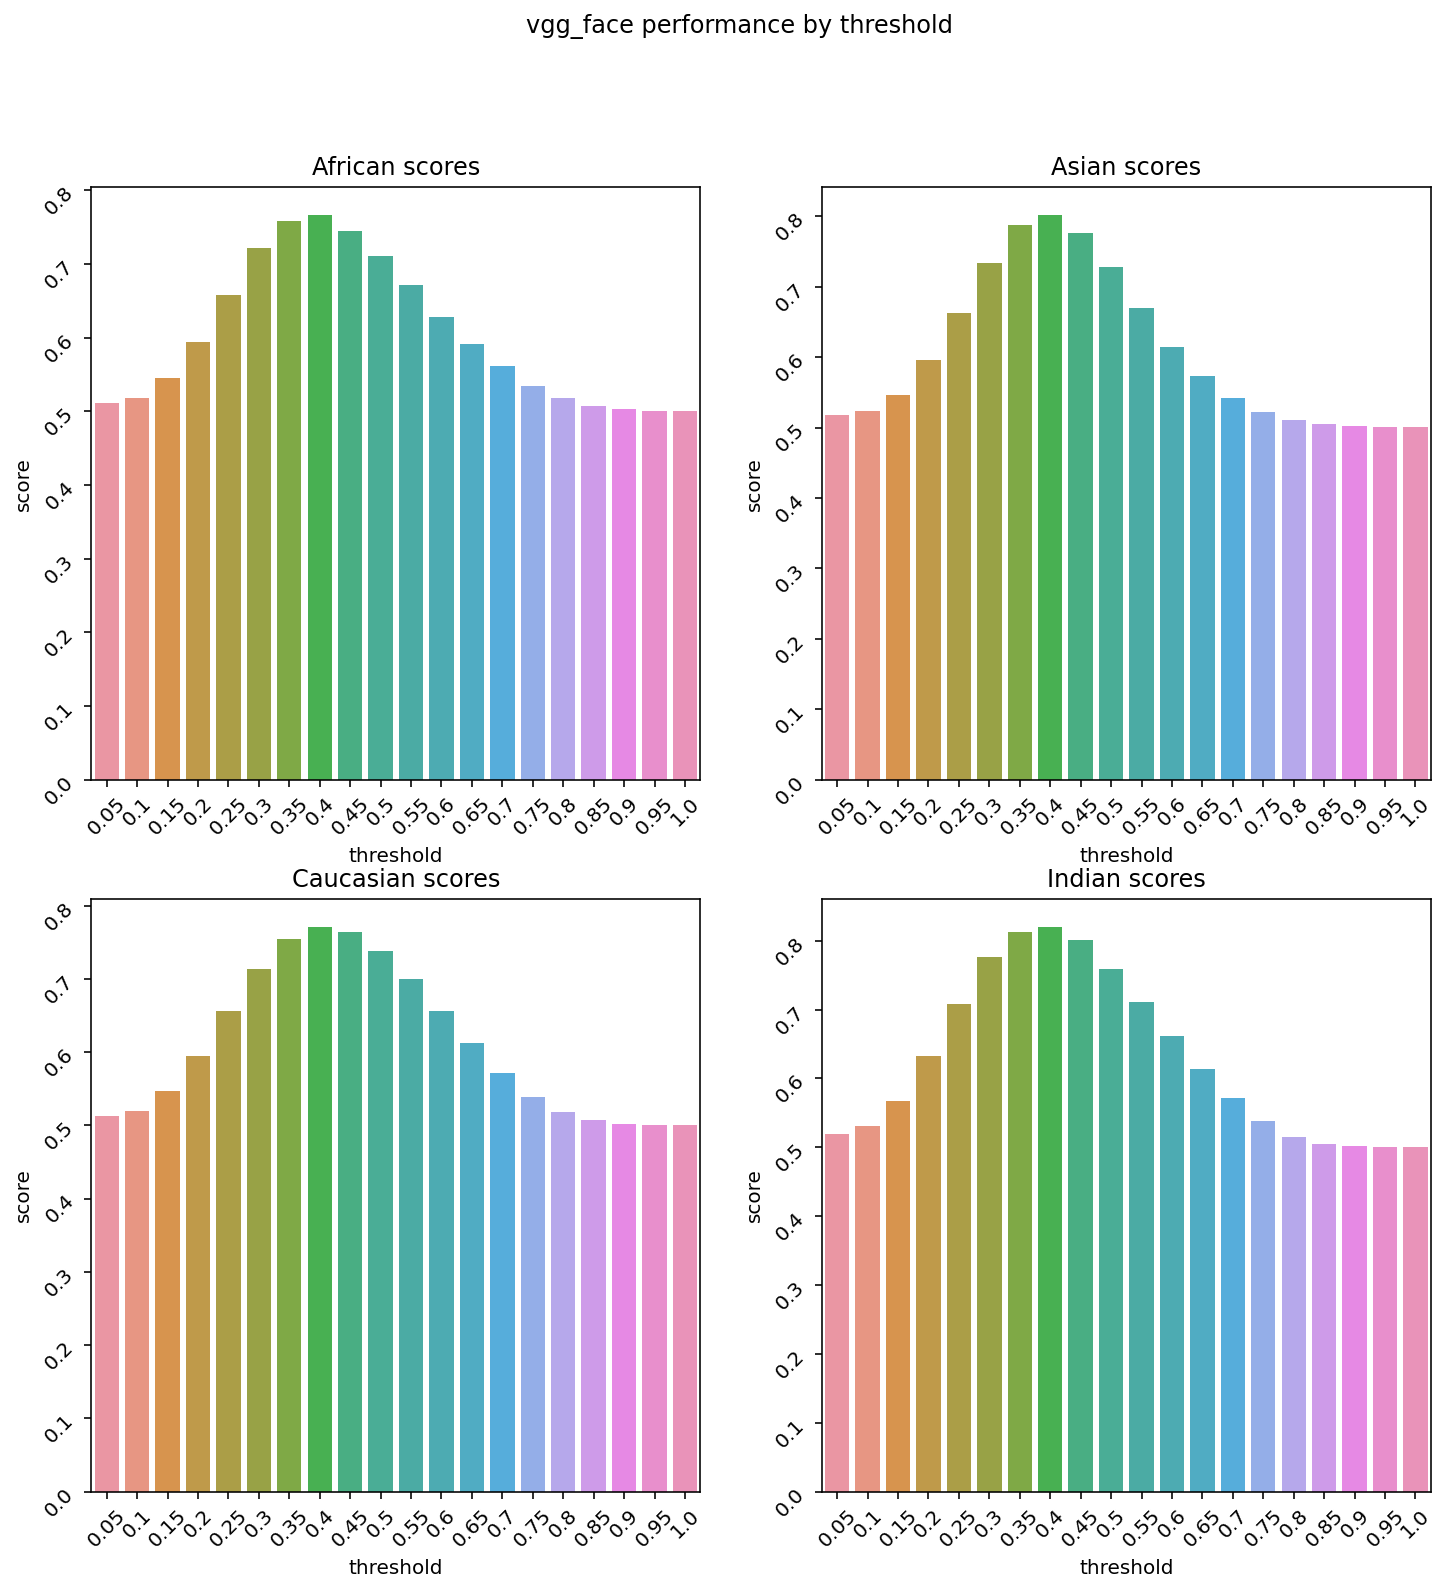

In [13]:
plot_performance_per_threshold('vgg_face')

**Result**:
* Overall performance is worse than with FaceNet512
* Mean performance is though only 6% difference between highest and lowest, indicating more fairness
* Varying performance for Asians again
* Partly overlapping CIs
* Thresholds are more fair which is reflected in the fair performance

### ArcFace

In [14]:
arcface_summary = get_metric_comparision('arcface', roc_auc_score)

arcface_summary.sort_values('mean', ascending=False)

,race,mean,lower_ci,higher_ci
0,Indian,0.836133,0.834679,0.837586
0,Asian,0.817488,0.816055,0.818921
0,Caucasian,0.810507,0.808832,0.812183
0,African,0.807461,0.805872,0.809049


In [15]:
arcface_summary = get_metric_comparision('arcface', accuracy_score)

arcface_summary.sort_values('mean', ascending=False)

,race,mean,lower_ci,higher_ci
0,Caucasian,0.658483,0.656569,0.660398
0,Indian,0.656597,0.654827,0.658366
0,African,0.641070,0.639372,0.642768
0,Asian,0.629000,0.627334,0.630666


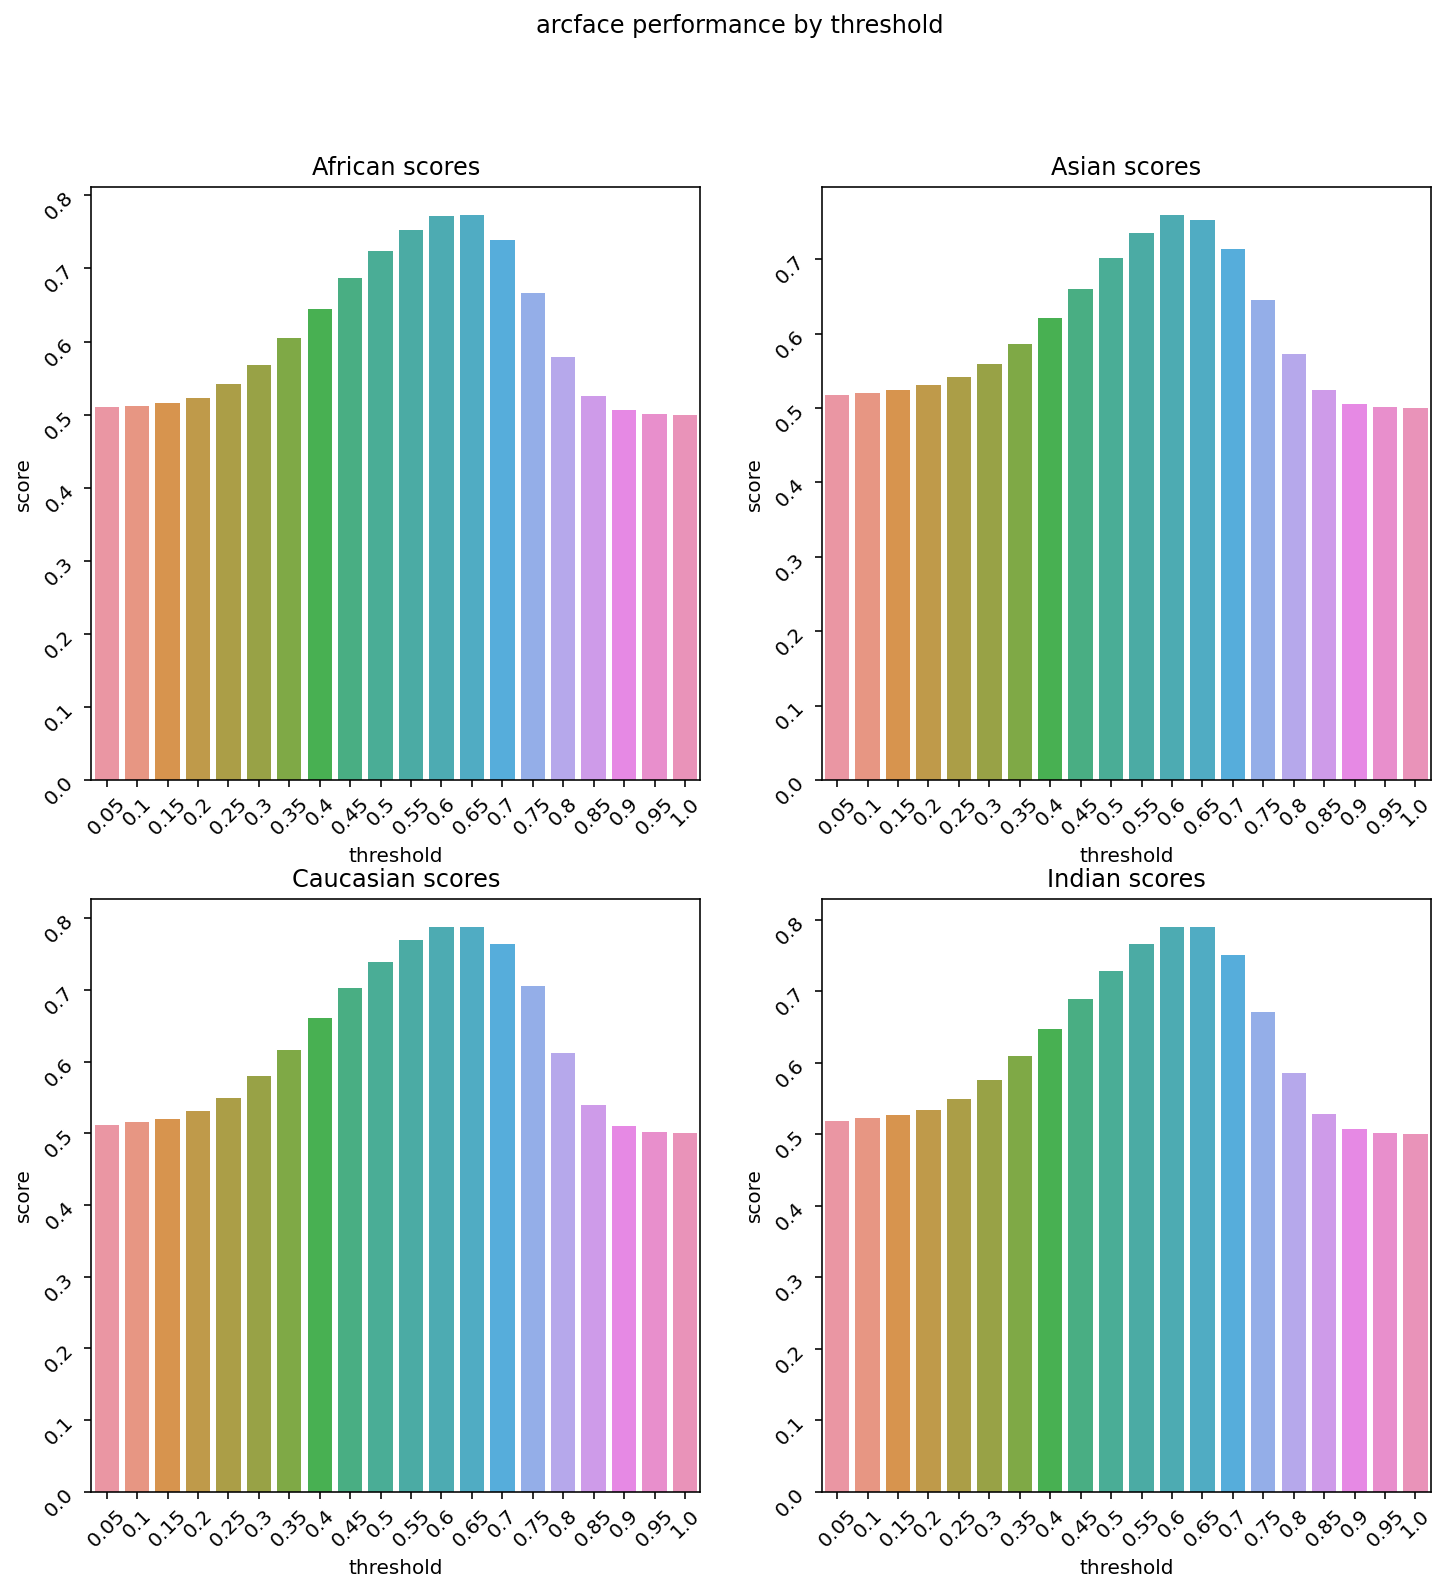

In [16]:
plot_performance_per_threshold('arcface')

**Result**:
* Worst overall performance
* Only 5% decrease between best and worst which seems to be fairer
* Asians again wide CI compared to e.g. Caucasian
* Best thresholds is shifted to the right but rather similar

## Distance distribution

This is the distribution of the predicted distance between the pairs. In a first plot they will be generally visualised and then paised on pairs vs. non-pairs.
An ideal model would predict two peaking curves on the outer ends of the plot indicating good discrimination.

### FaceNet512

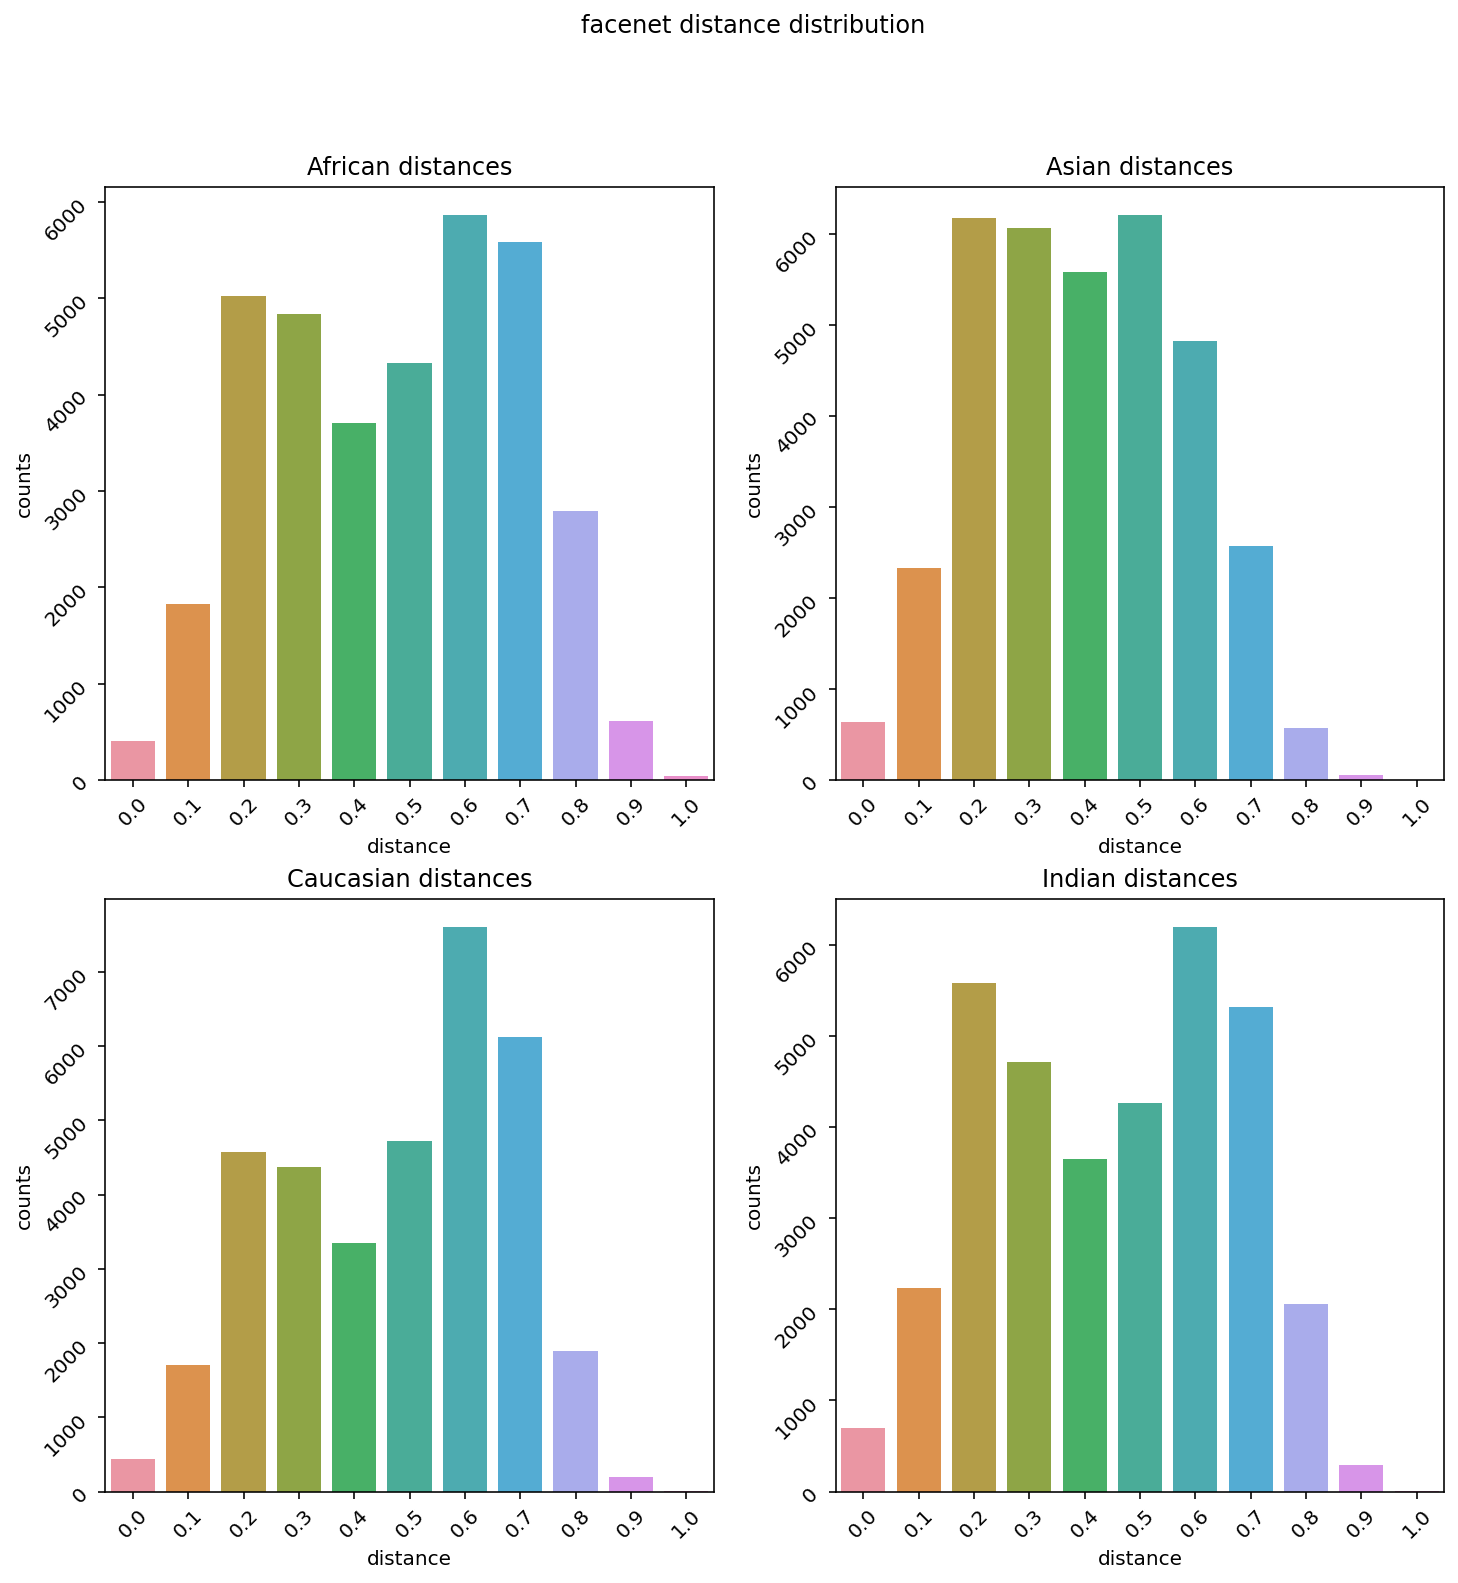

In [17]:
plot_score_distribution('facenet')

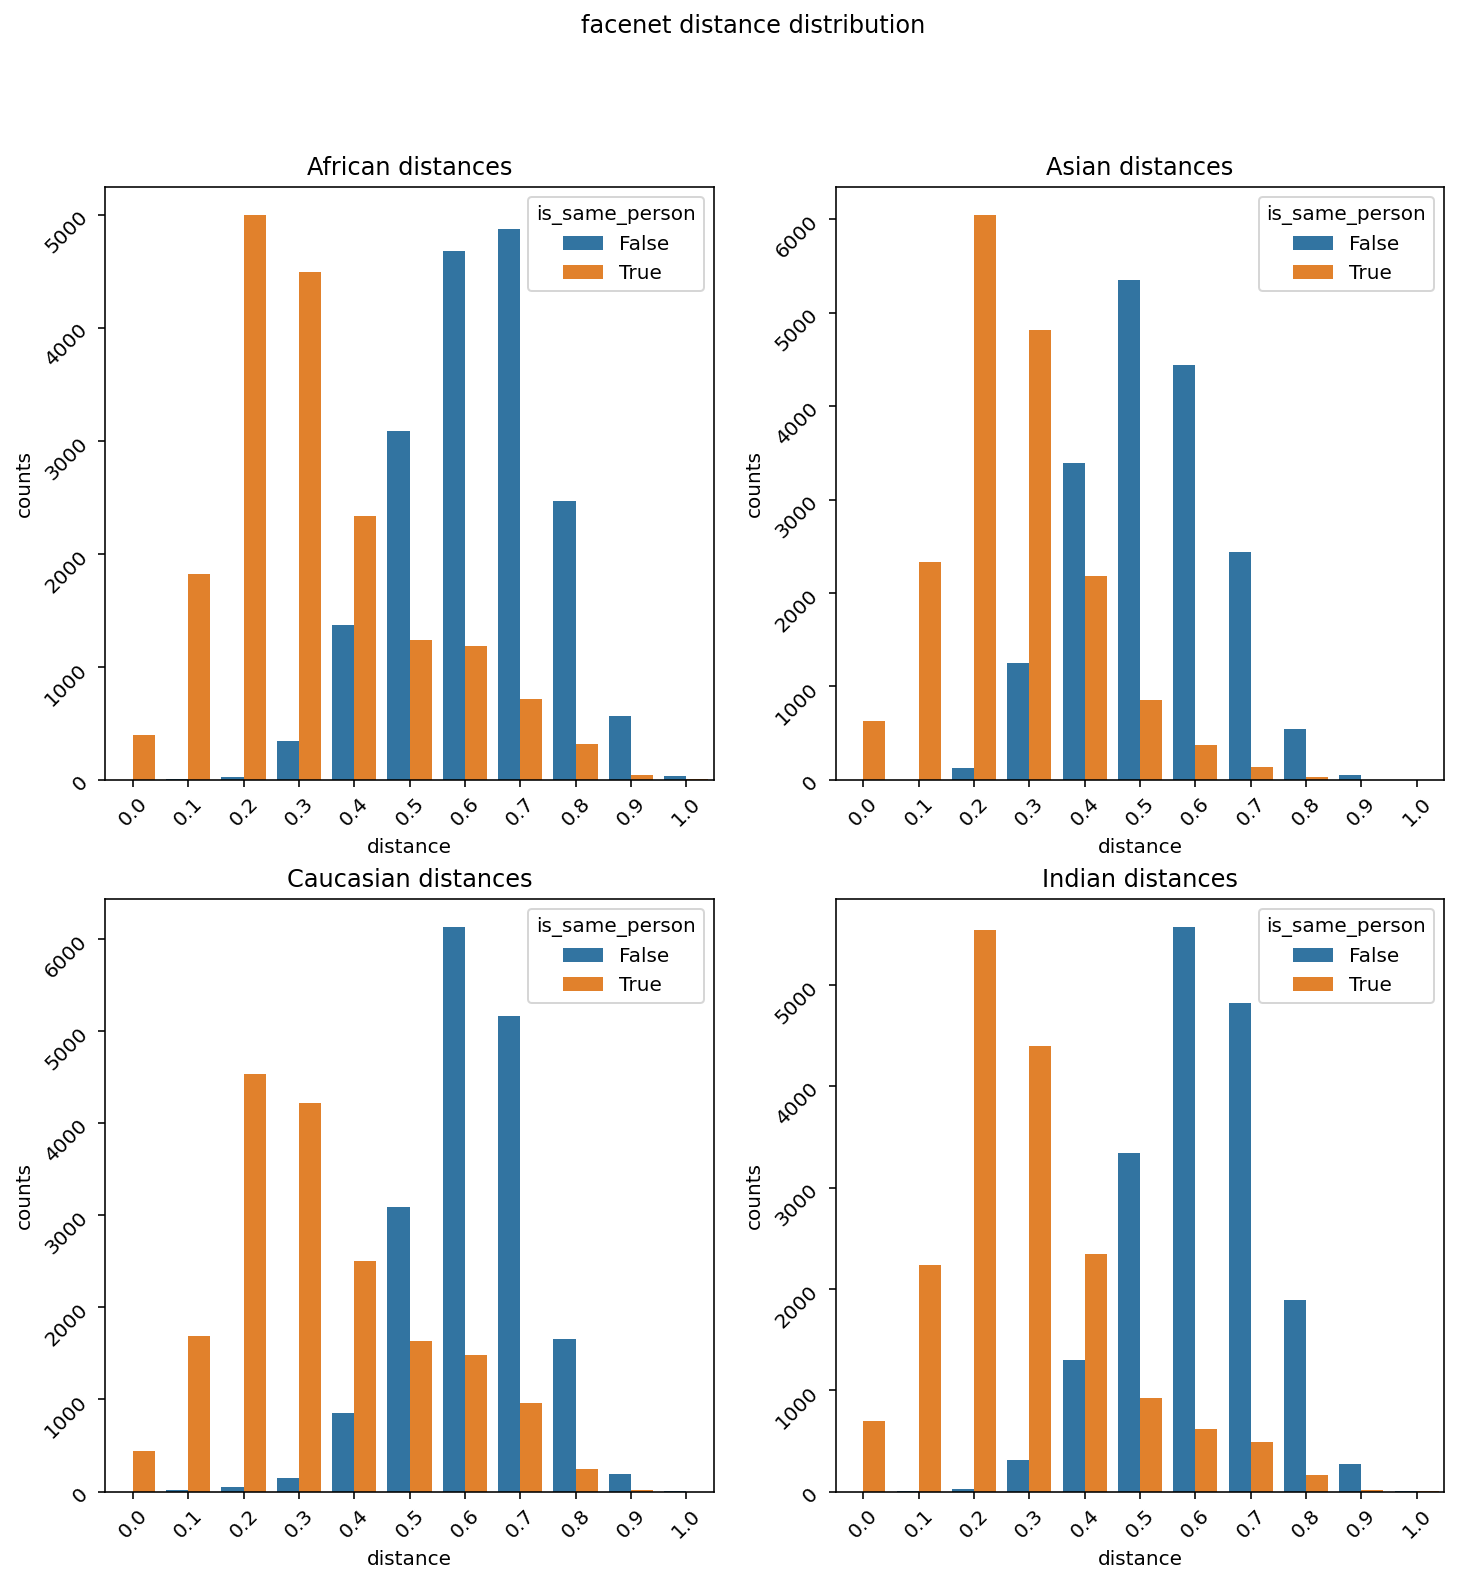

In [18]:
plot_score_distribution('facenet',groupby=['distance', 'is_same_person'], hue='is_same_person')

In [19]:
print("Asian difference in mean:",calculate_distribution_difference("facenet","Asian"))
print("African difference in mean:",calculate_distribution_difference("facenet","African"))
print("Caucasian difference in mean:",calculate_distribution_difference("facenet","Caucasian"))
print("Indian difference in mean:",calculate_distribution_difference("facenet","Indian"))

Asian difference in mean: -0.38653661125584865
African difference in mean: -0.4205054463960404
Caucasian difference in mean: -0.43622076503893936
Indian difference in mean: -0.46434932480726737


**Results**:
* Only the Asian model does not show two spiking parts. This means the distinction is done very badly. For the three other spikes are at least visible.
* All models have heavy overlaps which means there is always a trade off when choosing a threshold.
* Only the asian threshold is shifted to the left.

### VGG-Face


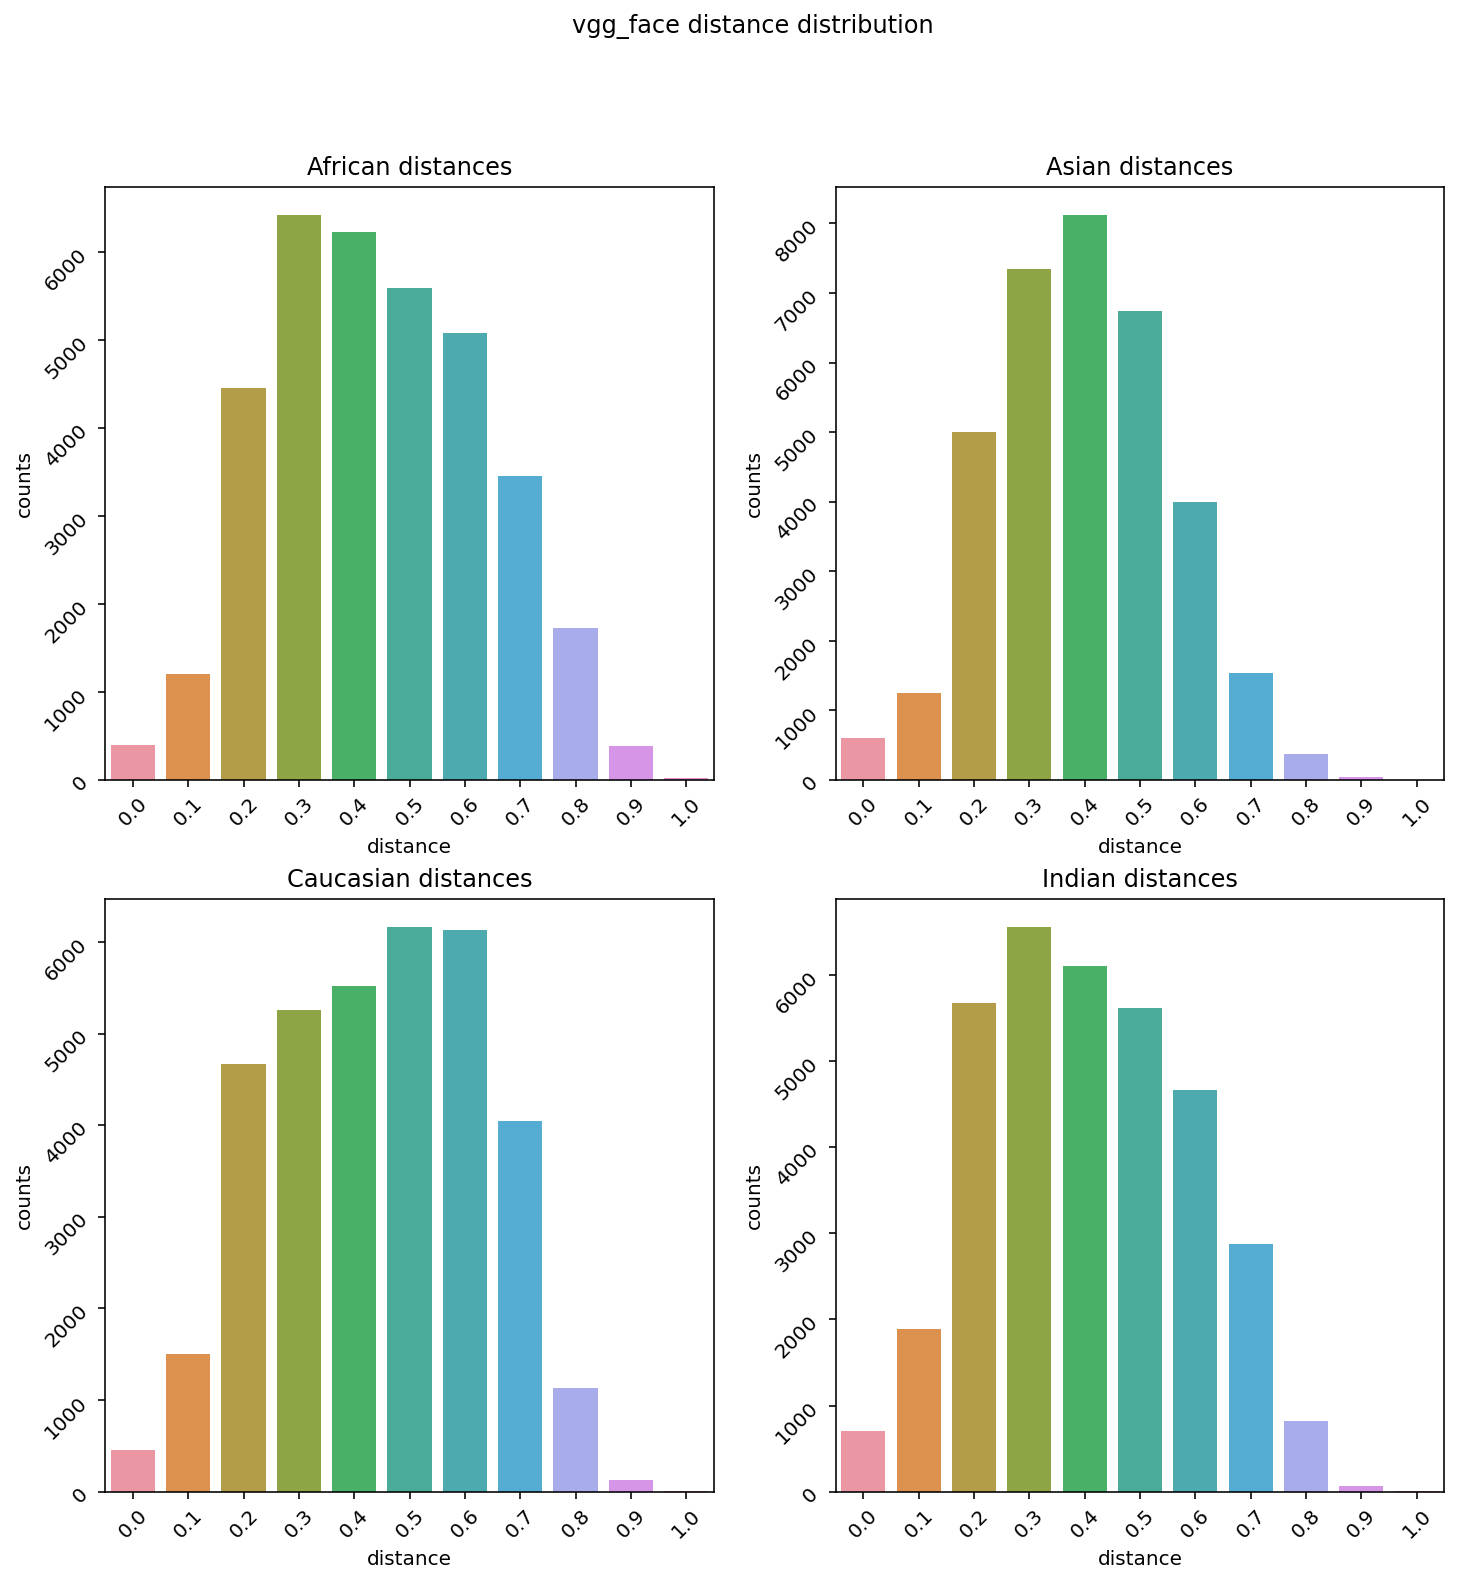

In [20]:
plot_score_distribution('vgg_face')

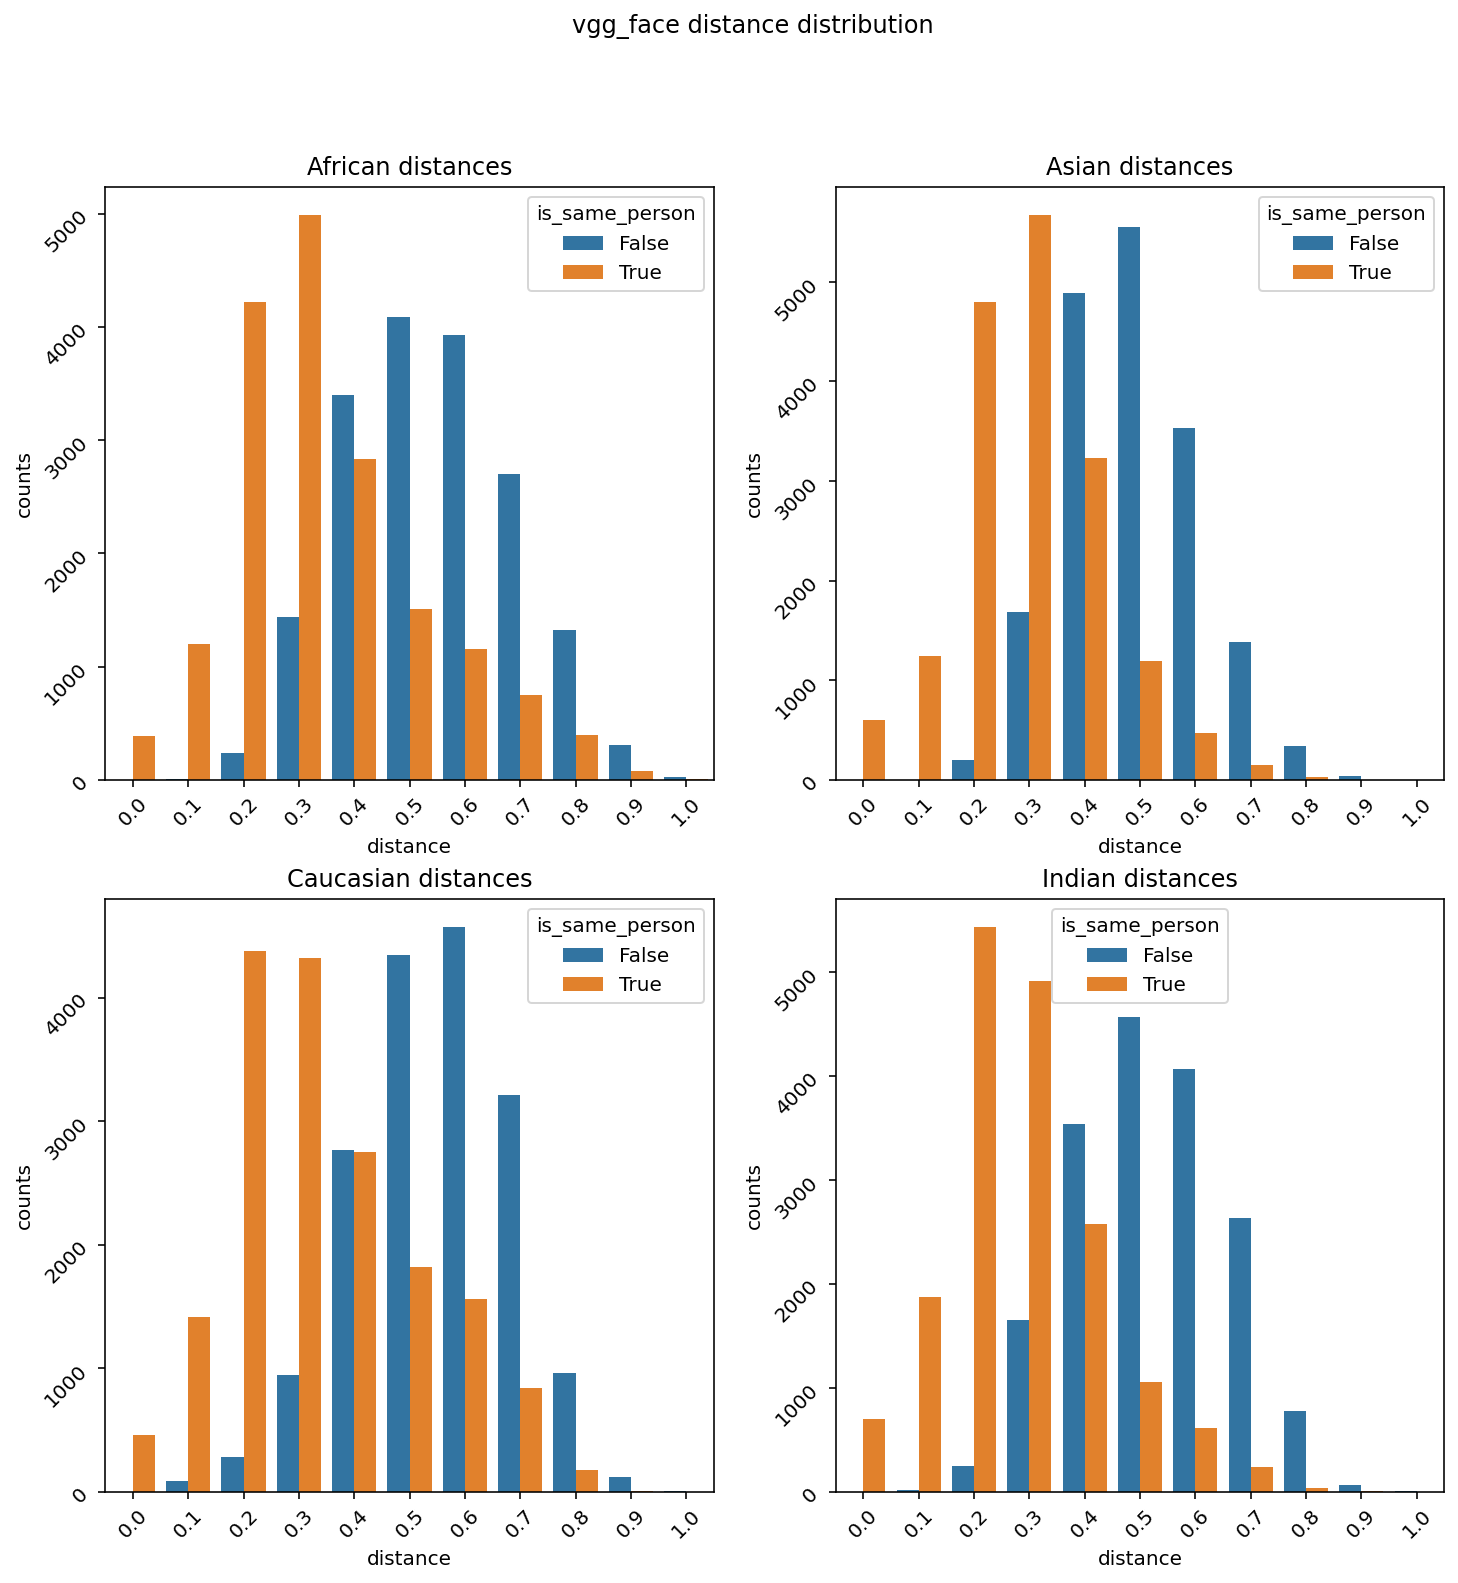

In [21]:
plot_score_distribution('vgg_face',groupby=['distance', 'is_same_person'], hue='is_same_person')

In [22]:
print("Asian difference in mean:",calculate_distribution_difference("vgg_face","Asian"))
print("African difference in mean:",calculate_distribution_difference("vgg_face","African"))
print("Caucasian difference in mean:",calculate_distribution_difference("vgg_face","Caucasian"))
print("Indian difference in mean:",calculate_distribution_difference("vgg_face","Indian"))

Asian difference in mean: -0.19801208285983862
African difference in mean: -0.19896174393870553
Caucasian difference in mean: -0.2304091349015886
Indian difference in mean: -0.2553912683651858


**Results**:
* No spikes in any ethnic group indicating bad discrimination.
* Even heavier overlaps = worse performance

### ArcFace

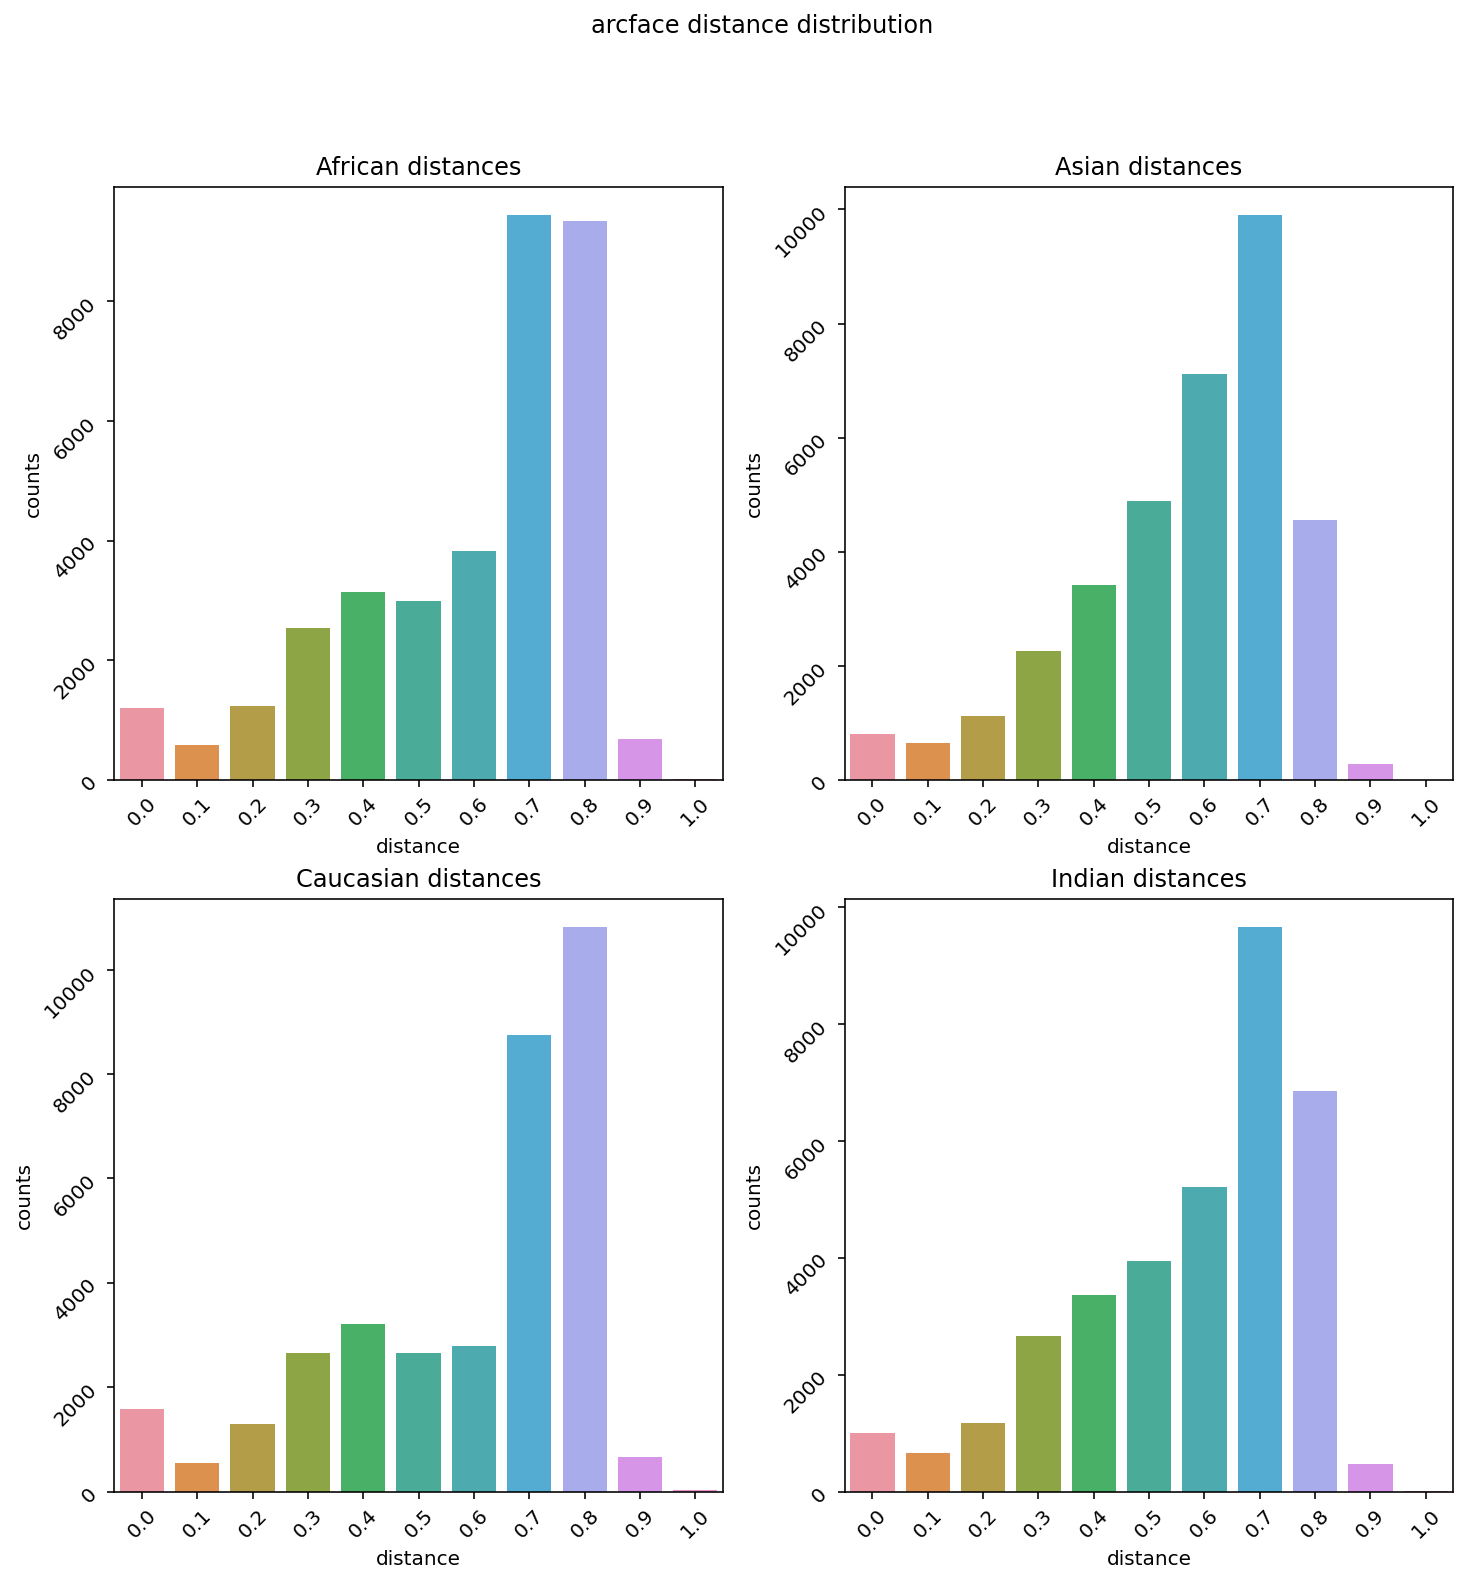

In [23]:
plot_score_distribution('arcface')

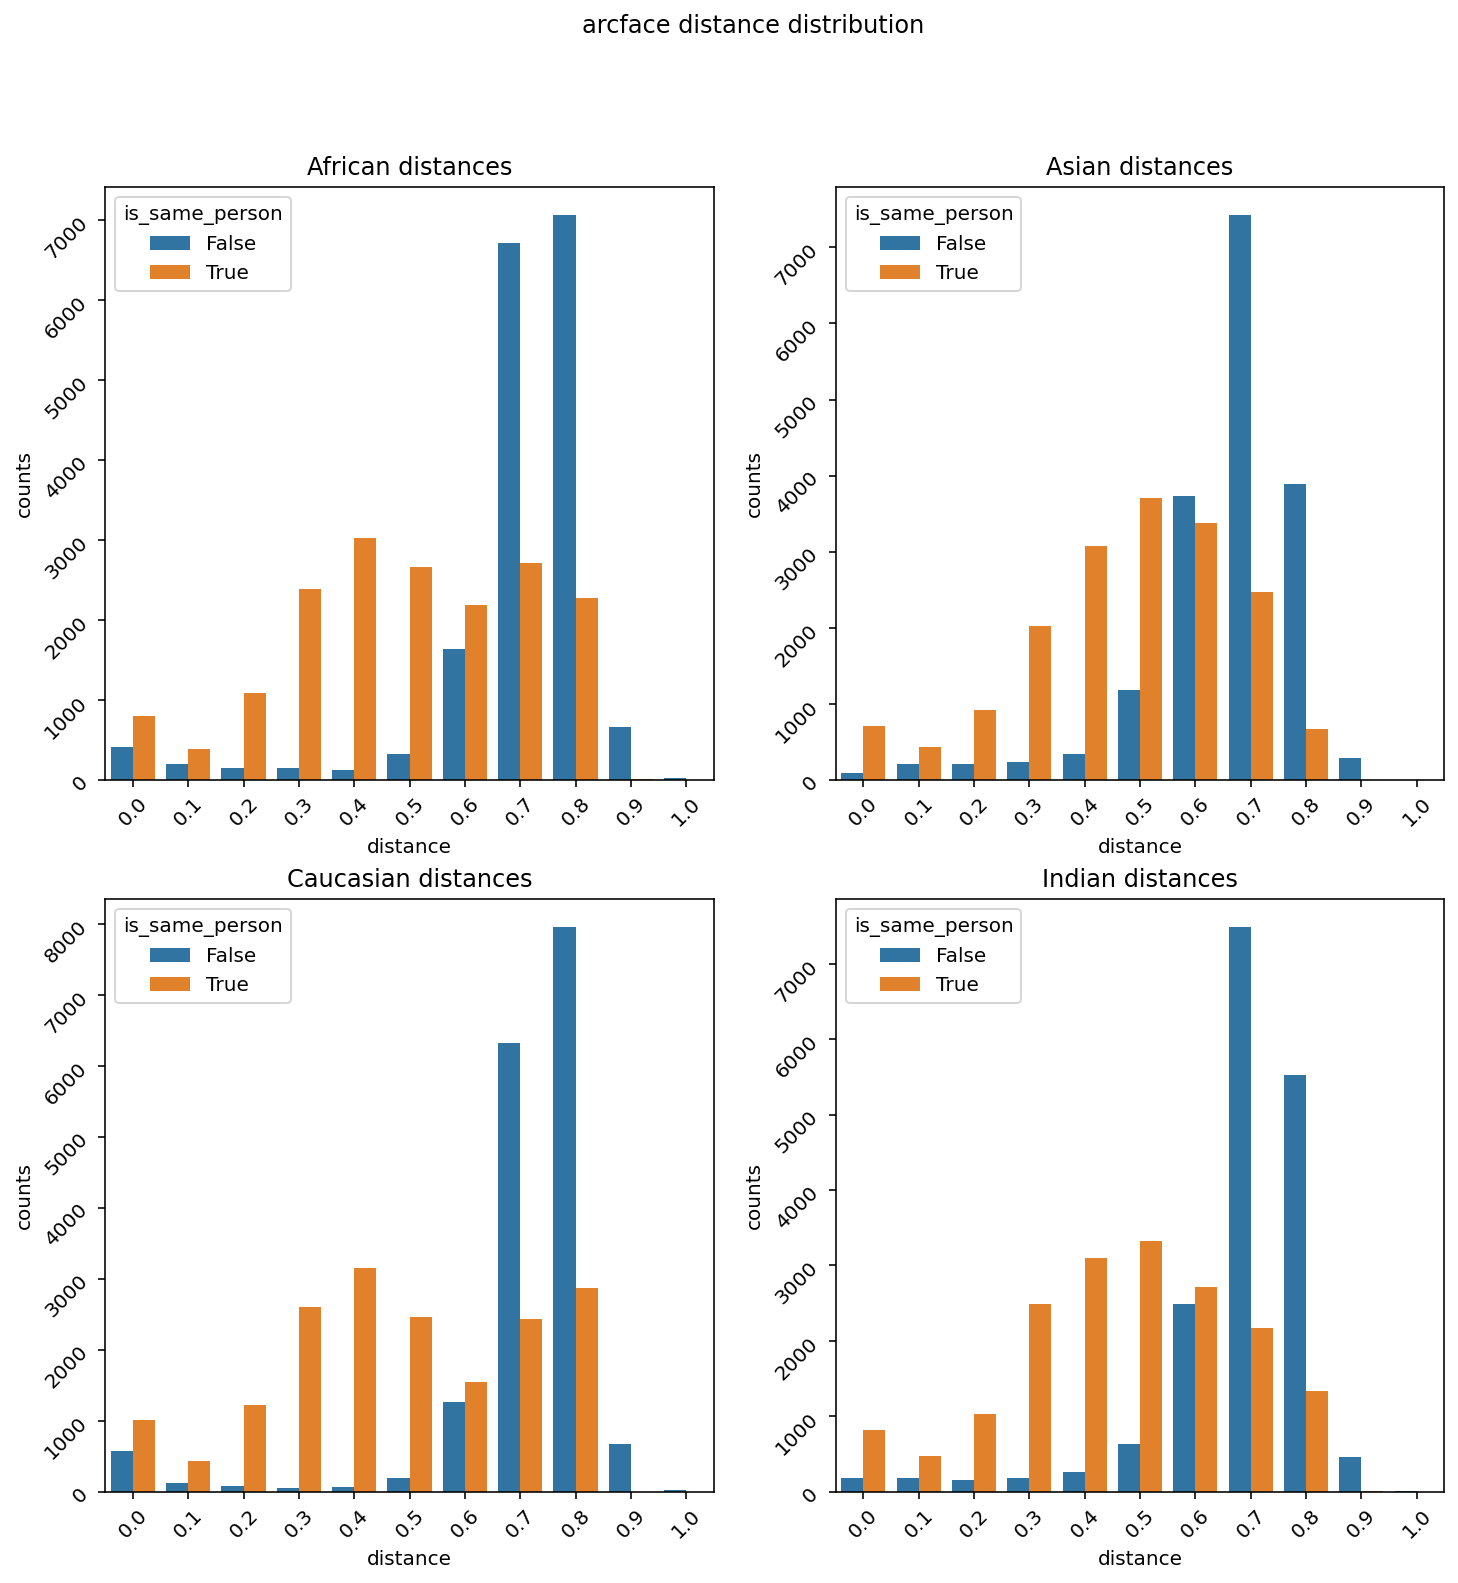

In [24]:
plot_score_distribution('arcface',groupby=['distance', 'is_same_person'], hue='is_same_person')

In [25]:
print("Asian difference in mean:",calculate_distribution_difference("arcface","Asian"))
print("African difference in mean:",calculate_distribution_difference("arcface","African"))
print("Caucasian difference in mean:",calculate_distribution_difference("arcface","Caucasian"))
print("Indian difference in mean:",calculate_distribution_difference("arcface","Indian"))

Asian difference in mean: -0.24197929846930433
African difference in mean: -0.2716768781358673
Caucasian difference in mean: -0.299395294880364
Indian difference in mean: -0.2811993843929874


**Results**:
* For all groups there are one or two spikes around 0.7 & 0.8
* Also the amount of non-pairs with 0 distance is significantly higher
* The distance of pairs is partly uniformly distributed (see African distances)
* Almost no discrimination power
* Generally big shift to the higher distances, might be due to geometric approach of ArcFace

## Paired significance tests

Usually a paired t-test would be the desired solution. However the normal distribution of the target variable is not fulfilled which is why we will go with a Wilcoxon-Signed-Rank-Test which is slightly less effective but has less assumptions.

The goal is to investigate if there are significant differences in the mean of the ethnic groups produced by a model. An unbiased model would present similar results. The two-sided test has the null hypothesis that the median of the differences is zero against the alternative that it is different from zero.

For independent sample we will use the Wilcoxon-RankSum-Test (NUll hypothesis = the observations come from the same population).

### General

The first step is to generate all possible combinations of comparisons

In [26]:
ethnic_groups =["Caucasian", "Asian","African", "Indian"]
unique_combinations = []
 
# Getting all permutations of list_1
# with length of list_2
permut = itertools.permutations(ethnic_groups, len(ethnic_groups))
 
# zip() is called to pair each permutation
# and shorter list element into combination
for comb in permut:
    zipped = zip(comb, ethnic_groups)
    unique_combinations.append(list(zipped))
 
flat_list = list(set([tuple(sorted(item)) for var_list in unique_combinations for item in var_list]))

### FaceNet512

In [27]:
model = "facenet"

for i in flat_list:
    if i[0]!=i[1]:
        _, p_value = perform_significance_test(model, i[0], i[1], test_type =st.ranksums)
        print(i)
        print(p_value)

('Asian', 'Caucasian')
0.0
('Caucasian', 'Indian')
0.0
('Asian', 'Indian')
2.77901737969199e-158
('African', 'Caucasian')
4.145608229744476e-281
('African', 'Indian')
1.765878713956982e-11
('African', 'Asian')
1.5243269666382885e-257


**Results**:
* Testing all combinations lets us reject all null hypothesises

### VGG-Face

In [28]:
model = "vgg_face"

for i in flat_list:
    if i[0]!=i[1]:
        _, p_value =  perform_significance_test(model, i[0], i[1], test_type =st.ranksums)
        print(i)
        print(p_value)

('Asian', 'Caucasian')
0.0
('Caucasian', 'Indian')
0.0
('Asian', 'Indian')
4.4756953106164787e-60
('African', 'Caucasian')
1.3466687614228911e-264
('African', 'Indian')
8.759635046022921e-18
('African', 'Asian')
3.8129904106784586e-147


**Results**:
* Testing all combinations lets us reject all null hypothesises

### ArcFace

In [29]:
model = "arcface"

for i in flat_list:
    if i[0]!=i[1]:
        _, p_value =  perform_significance_test(model, i[0], i[1], test_type =st.ranksums)
        print(i)
        print(p_value)

('Asian', 'Caucasian')
0.0
('Caucasian', 'Indian')
1.583270747415654e-238
('Asian', 'Indian')
2.8914311295260338e-15
('African', 'Caucasian')
7.29970585373292e-17
('African', 'Indian')
2.739325102636804e-141
('African', 'Asian')
1.714717075504765e-239


**Results**:
* Testing all combinations lets us reject all null hypothesises

## Image description with Lime

Differnent models identify different areas in an image as important. Here we want to compare which areas are important to which model.

Ideally the ethic groups should be described similarly.

### General

In [30]:
def load_image(shape,path,preprocessing = None):
    if preprocessing is not None:
        img = preprocessing(path)
        img = resize(img,shape)
    else:
        img = Image.open(path).resize(shape)
        img = np.array(img)
    return img

In [31]:
!pip install lime

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


### FaceNet512

In [32]:
# get example image
asian_img = load_image("Asian",shape=(160,160))
african_img = load_image("African",shape=(160,160))
caucasian_img = load_image("Caucasian",shape=(160,160))
indian_img = load_image("Indian",shape=(160,160))

TypeError: load_image() got multiple values for argument 'shape'

In [ ]:
facenet512 = DeepFace.build_model("Facenet512")

In [ ]:
plot_face_heatmap(facenet512, african_img)

In [ ]:
plot_face_heatmap(facenet512, asian_img)

In [ ]:
plot_face_heatmap(facenet512, caucasian_img)

In [ ]:
plot_face_heatmap(facenet512, indian_img)

### VGG-Face

In [ ]:
# get example image
asian_img = load_image("Asian",shape=(224,224))
african_img = load_image("African",shape=(224,224))
caucasian_img = load_image("Caucasian",shape=(224,224))
indian_img = load_image("Indian",shape=(224,224))

In [ ]:
vgg_face = DeepFace.build_model("VGG-Face")

In [ ]:
plot_face_heatmap(vgg_face, african_img)

In [ ]:
plot_face_heatmap(vgg_face, asian_img)

In [ ]:
plot_face_heatmap(vgg_face, caucasian_img)

In [ ]:
plot_face_heatmap(vgg_face, indian_img)

### ArcFace

In [ ]:
# get example image
asian_img = load_image("Asian",shape=(112,112))
african_img = load_image("African",shape=(112,112))
caucasian_img = load_image("Caucasian",shape=(112,112))
indian_img = load_image("Indian",shape=(112,112))

In [ ]:
arcface = DeepFace.build_model("ArcFace")

In [ ]:
plot_face_heatmap(arcface, african_img)

In [ ]:
plot_face_heatmap(arcface, asian_img)

In [ ]:
plot_face_heatmap(arcface, caucasian_img)

In [ ]:
plot_face_heatmap(arcface, indian_img)

**Results**:
* Caucasian image has important forehead on all models
* ArcFace does not detect same face patterns for African as others